## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint_what_happened support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [48]:
!pip install nltk
!pip install wordcloud

In [49]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_rows", 50)
#pd.set_option("display.max_colwidth", None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file
f = 'complaints_2021_05_14_08_16.json' # Write the path to your data file and load it

# returns JSON object as
# a dictionary
with open(f,'r') as file:
    data = json.load(file)
    df=pd.json_normalize(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

In [51]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [52]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [53]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [54]:
#Assign new column names
newCol=''
for col in df.columns:
    newCol=col
    newCol=newCol.replace('_', '',1)
    newCol=newCol.replace('source.','')
    df.rename(columns={col:newCol},inplace=True)

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [55]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'', np.nan, regex=True)
df.complaint_what_happened


,complaint_what_happened
0,NaN
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...
3,NaN
4,NaN
...,...
78308,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to..."
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica..."


In [56]:
df['complaint_what_happened'].isna().sum()

np.int64(57241)

In [57]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])
#df=df[df.complaint_what_happened.notna()]
df

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotional offers",2018-12-07T12:00:00-05:00,NC,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",Didn't receive advertised or promotional terms,Consent provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company charging your account,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",Problem with balance transfer,Consent 

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [58]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleaned_text(text):

    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces


    return text

In [59]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    tokens = nlp(text)
    return " ".join(token.lemma_ for token in tokens)


In [60]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
cleaned_rows = []
from tqdm import tqdm

for x in tqdm(df.complaint_what_happened):
    cleaned_rows.append({'complaint_what_happened':x, 'lemmatized_complaints':lemmatize_text(cleaned_text(x))})

df_clean = pd.DataFrame(cleaned_rows)


100%|██████████| 21072/21072 [11:35<00:00, 30.31it/s]


In [61]:
df_clean

,complaint_what_happened,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...
...,...,...
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday I call chas my visa credit card provider and ask how to make a claim under their pu...
21069,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with pay and do not understand the great risk this provide to consumer I belie...
21070,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically since...


In [62]:
#Write your function to extract the POS tags
tqdm.pandas()
def pos_tag(text):
  # write your code here
  doc=nlp(text)
  return " ".join([token.text for token in doc if token.tag_=='NN'])


df_clean["complaint_POS_removed"] =df_clean['lemmatized_complaints'].progress_apply(pos_tag)  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|██████████| 21072/21072 [11:15<00:00, 31.19it/s]


In [63]:
#The clean dataframe should now contain the raw complaint_what_happened, lemmatized complaint_what_happened and the complaint_what_happened after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...,morning name stop service debt verification statement bank debt mail month debt right informatio...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...
...,...,...,...
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday I call chas my visa credit card provider and ask how to make a claim under their pu...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...
21069,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with pay and do not understand the great risk this provide to consumer I belie...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...
21070,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically since...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




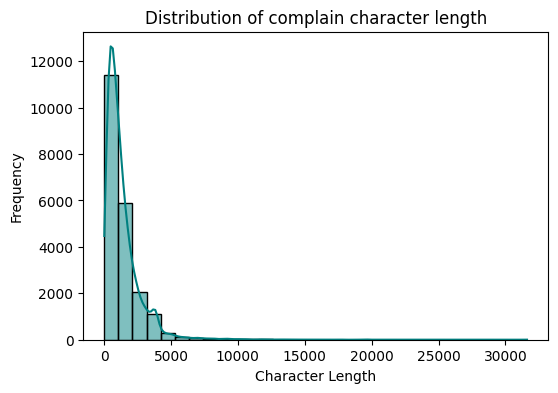

In [64]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(6,4))
sns.histplot(df['complaint_what_happened'].str.len(),bins=30,kde=True,color='teal')
plt.title('Distribution of complain character length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

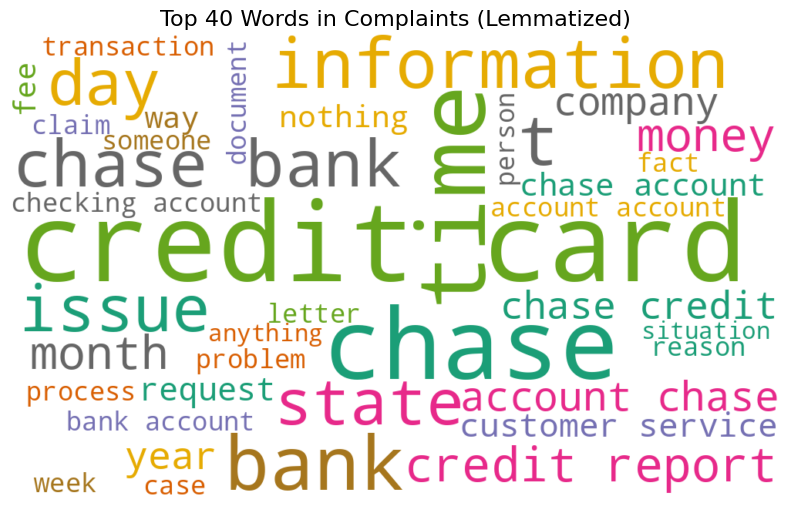

In [65]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
def find_top_words_by_frequency(data,topn=40):
    wordcloud = WordCloud(width=1000, height=600, max_words=topn, background_color='white', colormap='Dark2').generate(" ".join(data))
    # Display the word cloud
    plt.figure(figsize=(20,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top 40 Words in Complaints (Lemmatized)", fontsize=16)
    plt.show()
find_top_words_by_frequency(df_clean['complaint_POS_removed'])

In [66]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

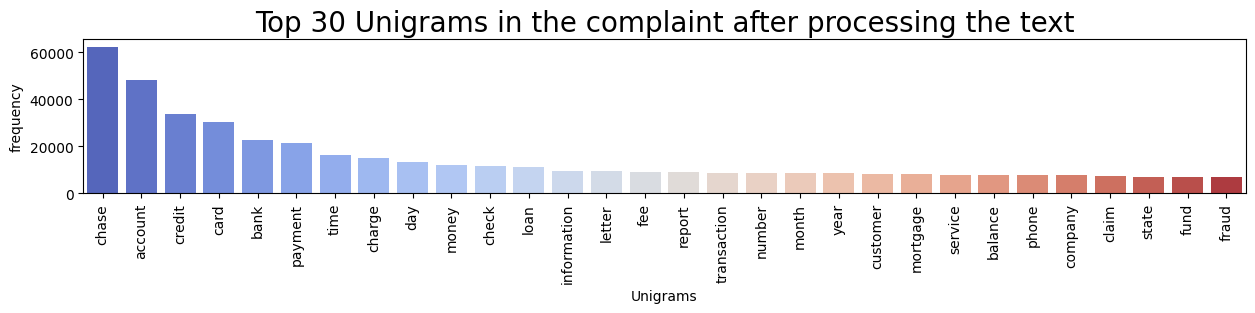

In [67]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def top_ngrams(corpus,name,ngram_range=(1,1),topn=30):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:topn]
    df_top= pd.DataFrame(words_freq, columns=[name, 'frequency'])
    # Plot the top 30 unigrams
    plt.figure(figsize=(15,2))
    sns.barplot(x=name, y='frequency', data=df_top, palette="coolwarm", legend=False,hue=name)
    plt.xticks(rotation=90)
    plt.title(f"Top {topn} {name} in the complaint after processing the text", fontsize=20)
    plt.show()
    return df_top

top_unigrams = top_ngrams( df_clean['Complaint_clean'],'Unigrams', (1,1),30)

In [68]:
#Print the top 10 words in the unigram frequency
top_unigrams.head(10)

,Unigrams,frequency
0,chase,62287
1,account,47960
2,credit,33732
3,card,30494
4,bank,22543
5,payment,21360
6,time,16308
7,charge,14956
8,day,13312
9,money,11985


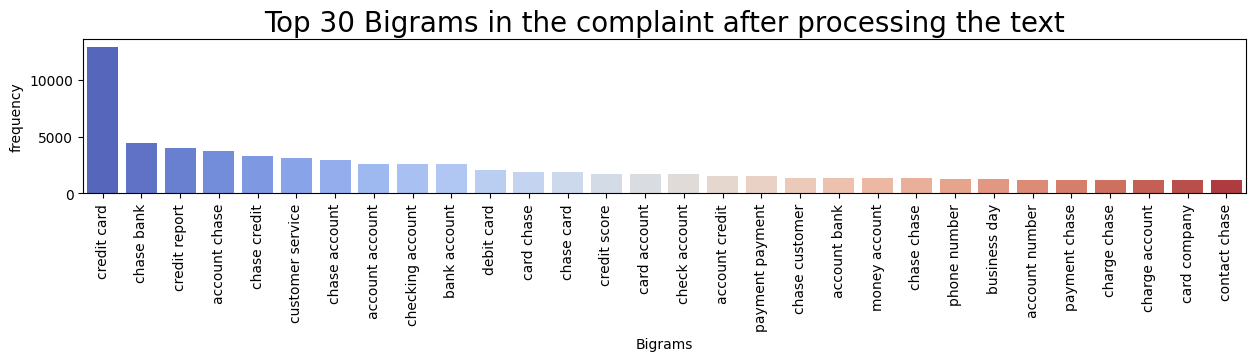

In [69]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_bigrams = top_ngrams(df_clean['Complaint_clean'],'Bigrams', (2,2), 30)

In [70]:
#Print the top 10 words in the bigram frequency
top_bigrams.head(10)


,Bigrams,frequency
0,credit card,12936
1,chase bank,4418
2,credit report,3983
3,account chase,3701
4,chase credit,3259
5,customer service,3089
6,chase account,2969
7,account account,2579
8,checking account,2553
9,bank account,2550


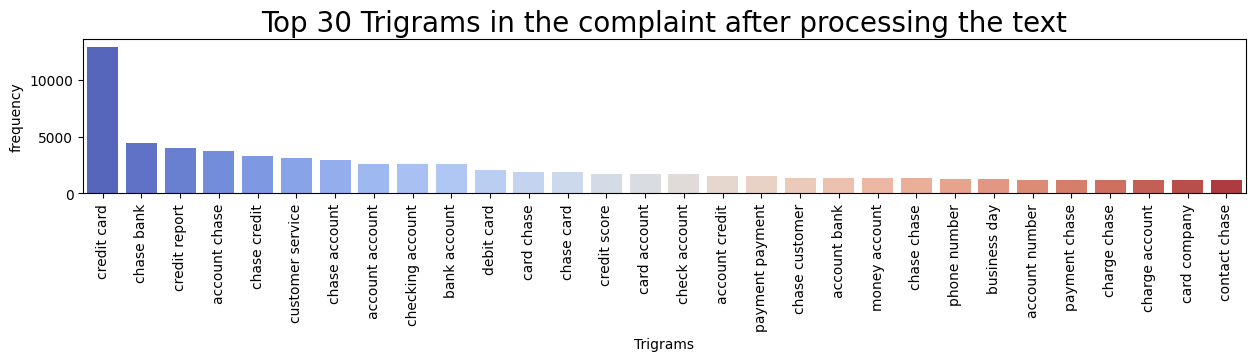

In [71]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_trigrams = top_ngrams(df_clean['Complaint_clean'],'Trigrams', (2,2), 30)

In [72]:
#Print the top 10 words in the trigram frequency
top_trigrams.head(10)

,Trigrams,frequency
0,credit card,12936
1,chase bank,4418
2,credit report,3983
3,account chase,3701
4,chase credit,3259
5,customer service,3089
6,chase account,2969
7,account account,2579
8,checking account,2553
9,bank account,2550


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [73]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [74]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...,card agent anniversary date agent information order account change anniversary date consent reco...
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...
...,...,...,...,...
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday I call chas my visa credit card provider and ask how to make a claim under their pu...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...
21069,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with pay and do not understand the great risk this provide to consumer I belie...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...
21070,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically since...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [75]:
#Write your code here to initialise the TfidfVectorizer

tfidf= TfidfVectorizer(stop_words='english',max_df=0.95,min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [76]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [77]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [78]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)#write your code here


In [79]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6535

In [80]:
#Print the Top15 words for each of the topics
def display_topics(model, feature_names, no_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words)
        print(f'\033[1mTHE TOP 15 WORDS FOR TOPIC #{topic_idx + 1}', '\033[0m')
        print(f" {' | '.join(top_words)}")
    return topics

topic_keywords = display_topics(nmf_model, tfidf.get_feature_names_out(),15)

THE TOP 15 WORDS FOR TOPIC #1 
 account | check | bank | money | chase | fund | deposit | branch | day | checking | transaction | number | claim | business | transfer
THE TOP 15 WORDS FOR TOPIC #2 
 card | charge | chase | credit | dispute | fee | transaction | purchase | service | fraud | merchant | balance | time | company | statement
THE TOP 15 WORDS FOR TOPIC #3 
 loan | mortgage | chase | home | modification | property | year | letter | time | document | rate | foreclosure | house | sale | request
THE TOP 15 WORDS FOR TOPIC #4 
 credit | report | inquiry | card | account | score | debt | company | information | reporting | identity | chase | application | bureau | limit
THE TOP 15 WORDS FOR TOPIC #5 
 payment | balance | month | fee | statement | auto | day | time | chase | credit | date | account | year | pay | mortgage


In [ ]:
#Create the best topic for each complaint_what_happened in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)


array([2, 1, 3, ..., 1, 4, 4])

In [82]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis = 1)#write your code to assign topics to each rows.

In [83]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,2
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...,card agent anniversary date agent information order account change anniversary date consent reco...,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0


In [84]:
#Print the first 5 Complaint for each of the Topics
df_clean5=df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On ...,with out notice j p morgan chase restrict my account by my debit card tuesday on thursday I go i...,chase account debit card branch customer service representative account branch fund deposit plac...,chase account debit card branch customer service representative account branch fund deposit plac...,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0
12,I opened an account with chase bank on XXXX and used a code for XXXX bonus. I called to follow u...,I open an account with chase bank on and use a code for bonus I call to follow up on about the t...,account bank code bonus term everything account deposit bonus day require deposit account coupon...,account bank code bonus term everything account deposit bonus day require deposit account coupon...,0
10,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and,mishandle account auto,mishandle account auto,0
15,I opened the saving account for the {$25.00} bonus. I was supposed to received the {$25.00} bonu...,I open the save account for the bonus I be suppose to received the bonus after consecutive auto ...,save account bonus bonus auto transfer check transfer fund checking account fund account request...,save account bonus bonus auto transfer check transfer fund checking account fund account request...,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with ...",on I make a payment to an online retailer use chase quick pay with on the chase website I realiz...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...,card agent anniversary date agent information order account change anniversary date consent reco...,1
13,"To whom it may concern, Chase bank charged wrongly overdraft fees, I have alert of low balance o...",to whom it may concern chase bank charge wrongly overdraft fee I have alert of low balance or un...,concern charge overdraft fee alert balance unsuficent fee balance transaction chase order overdr...,concern charge overdraft fee alert balance unsuficent fee balance transaction chase order overdr...,1
14,My chase amazon card was declined for a catering order I had placed for my brothers funeral in t...,my chase amazon card be decline for a catering order I have place for my brother funeral in the ...,chase amazon card decline catering order place brother funeral amount contact chase noon today n...,chase amazon card decline catering order place brother funeral amount contact chase noon today n...,1
16,"XXXX XXXX a sofa, love seat, table and chairs and was never delivered. Debit card charged {$2400...",a sofa love seat table and chair and be never deliver debit card charge bank say visa deny cla...,sofa love seat table chair debit card charge bank visa claim furniture money,sofa love seat table chair debit card charge bank visa claim furniture money,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [85]:
#Create the dictionary of Topic names and Topics
Topic_names = {

    0: 'Bank Account service',
    1: 'Theft/Dispute Reporting',
    2: 'Mortgage/Loan',
    3: 'Credi card or prepaid card',
    4: 'Others'

}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [86]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,Mortgage/Loan
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...,card agent anniversary date agent information order account change anniversary date consent reco...,Theft/Dispute Reporting
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,Credi card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,Credi card or prepaid card
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,Bank Account service
...,...,...,...,...,...
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,Theft/Dispute Reporting
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday I call chas my visa credit card provider and ask how to make a claim under their pu...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with pay and do not understand the great risk this provide to consumer I belie...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,Theft/Dispute Reporting
21070,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically since...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [87]:
#Create the dictionary again of Topic names and Topics
import warnings as warnings
warnings.filterwarnings("ignore")
Topic_names = {
    'Bank Account service':0,
    'Theft/Dispute Reporting':1,
    'Mortgage/Loan':2,
    'Credi card or prepaid card':3,
    'Others':4

}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [88]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmem...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,2
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not c...,card agent anniversary date agent information order account change anniversary date consent reco...,card agent anniversary date agent information order account change anniversary date consent reco...,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my con...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a ticket I come across an offer for to be apply towards the ticket if I app...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank m...,3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0
...,...,...,...,...,...
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday I call chas my visa credit card provider and ask how to make a claim under their pu...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...,visa credit card provider claim purchase protection benefit school tetbook year daughter school ...,1
21069,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with pay and do not understand the great risk this provide to consumer I belie...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,1
21070,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically since...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...,credit yrs credit card chase freedom problem balance transfer life plenty eperience balance tran...,4


In [89]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Topic','complaint_what_happened']]

In [90]:
training_data

,Topic,complaint_what_happened
0,2,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...
1,1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...
2,3,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id..."
3,3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t..."
4,0,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...
...,...,...
21067,1,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for..."
21068,1,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to..."
21069,1,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...
21070,4,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica..."


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [91]:

#Write your code to get the Vector count
count_vectorizer = CountVectorizer(stop_words='english')

#Write your code here to transform the word vector to tf-idf
count_matrix = count_vectorizer.fit_transform(df_clean['complaint_what_happened'])


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [92]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [93]:
# Write your code here to build any 3 models and evaluate them using the required metrics

def plot_confusion_matrix(cm, classes, model_name="Model", figsize=(4,4), cmap="Blues"):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=14)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(criterion='gini' ,min_samples_leaf=15, max_depth=30, max_features=None,random_state=42),
        "Random Forest": RandomForestClassifier(criterion='gini', n_estimators=100,min_samples_split=5, min_samples_leaf=5, max_features=None, max_depth=30,random_state=42),
        "Naive Base": MultinomialNB(alpha=0.1)
    }

    results = []

    for model_name, model in tqdm (models.items()):
        print(f"\n🔹 Evaluating Model: {model_name}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, digits=3)
        cm = confusion_matrix(y_test, y_pred)

        print("Classification Report:\n", report)
        print(f"Accuracy: {acc:.4f}")

        # Plot CM
        plot_confusion_matrix(cm, classes=np.unique(y_test), model_name=model_name)

        results.append({
            'model': model_name,
            'accuracy': acc,
            'report': report,
            'confusion_matrix': cm
        })

    return results

  0%|          | 0/4 [00:00<?, ?it/s]


🔹 Evaluating Model: Logistic Regression
Classification Report:
               precision    recall  f1-score   support

           0      0.945     0.949     0.947      1152
           1      0.934     0.940     0.937      1259
           2      0.946     0.934     0.940       729
           3      0.933     0.930     0.932       603
           4      0.940     0.934     0.937       472

    accuracy                          0.940      4215
   macro avg      0.940     0.938     0.939      4215
weighted avg      0.940     0.940     0.939      4215

Accuracy: 0.9395


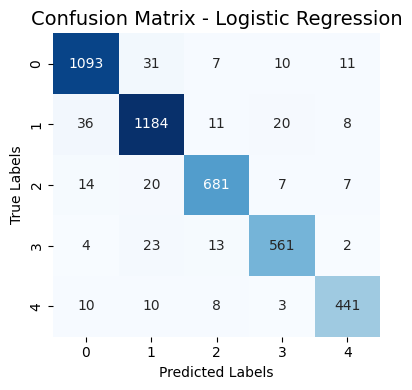

 25%|██▌       | 1/4 [02:43<08:10, 163.50s/it]


🔹 Evaluating Model: Decision Tree
Classification Report:
               precision    recall  f1-score   support

           0      0.799     0.806     0.803      1152
           1      0.772     0.818     0.794      1259
           2      0.838     0.783     0.810       729
           3      0.757     0.687     0.720       603
           4      0.744     0.771     0.758       472

    accuracy                          0.785      4215
   macro avg      0.782     0.773     0.777      4215
weighted avg      0.785     0.785     0.784      4215

Accuracy: 0.7848


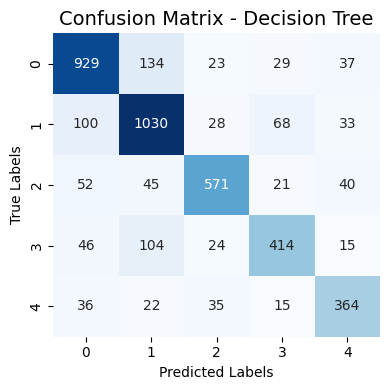

 50%|█████     | 2/4 [02:46<02:18, 69.33s/it] 


🔹 Evaluating Model: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0      0.861     0.852     0.856      1152
           1      0.828     0.856     0.842      1259
           2      0.876     0.818     0.846       729
           3      0.813     0.766     0.789       603
           4      0.774     0.862     0.816       472

    accuracy                          0.836      4215
   macro avg      0.831     0.831     0.830      4215
weighted avg      0.837     0.836     0.836      4215

Accuracy: 0.8361


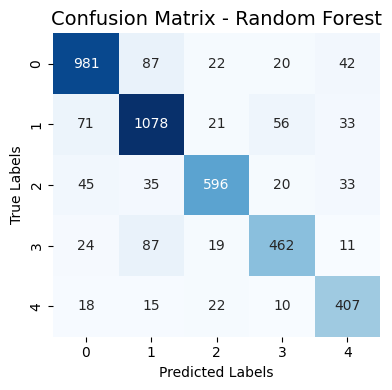

 75%|███████▌  | 3/4 [09:03<03:29, 209.42s/it]


🔹 Evaluating Model: Naive Base
Classification Report:
               precision    recall  f1-score   support

           0      0.852     0.862     0.857      1152
           1      0.887     0.776     0.828      1259
           2      0.889     0.827     0.857       729
           3      0.723     0.859     0.785       603
           4      0.666     0.782     0.719       472

    accuracy                          0.821      4215
   macro avg      0.804     0.821     0.809      4215
weighted avg      0.830     0.821     0.823      4215

Accuracy: 0.8209


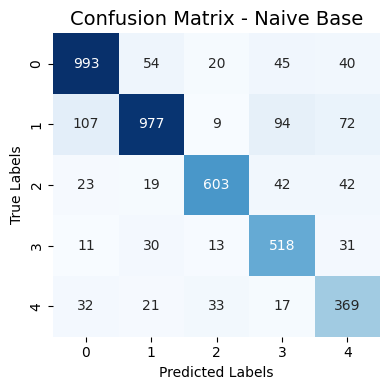

100%|██████████| 4/4 [09:03<00:00, 135.89s/it]


In [94]:
X_train, X_test, y_train, y_test = train_test_split(count_matrix, training_data.Topic, test_size=0.2, random_state=42)
results = evaluate_models(X_train, X_test, y_train, y_test)

## Inference:

| Model                     | Accuracy  | Macro F1  | Comments                                                                   |
| ------------------------- | --------- | --------- | -------------------------------------------------------------------------- |
|**Logistic Regression** | **0.940** | **0.939** | Best performing model — high, balanced precision/recall across all classes |
| Random Forest             | 0.836     | 0.830     | Good performance, slight dip in class consistency                          |
| Naive Bayes               | 0.821     | 0.809     | Decent; overestimates some classes, underperforms on others                |
| Decision Tree             | 0.785     | 0.777     | Weakest overall — unstable class-wise recall/precision                     |



## Conclusion:

1. **Logistic Regression (Best Performing Model)**

    Achieves consistently high precision, recall, and F1-scores across all classes.

    Well-balanced model and ideal for deployment in its current state.

    Recommended as the final model for the task.

2. **Random Forest (Good Alternative)**

    Performs well but slightly inconsistent across classes (notably lower precision for class 4).

    Could be enhanced with hyperparameter tuning or class balancing.

    Suitable for use if nonlinear relationships are important.

3. **Naive Bayes**

    Decent performance on most classes, but suffers from lower precision in class 4.

    Fast and lightweight, but assumptions of feature independence may limit performance.

4. **Decision Tree (Least Effective)**

    Shows inconsistent performance, especially poor for class 3 recall.

    Likely overfitting or underfitting due to lack of depth control or pruning.

    Not recommended without significant tuning.

## Final Recommendation

- Use Logistic Regression as the primary model — it's accurate, balanced, and interpretable.

- Optionally, experiment with Random Forest or XGBoost for further performance improvement.

- Ensure class distributions are handled properly (e.g., oversampling, class_weight='balanced') for better generalization.